initiaze complete:
  solver: None
 ---- hyperparameter ----
  hyperparameter: tau_tilde=1.0
 ---- space ----
  space: nx=500, dx=0.0020, Lx=1.0
 ---- velocity ----
  velocity: nv=200, dv=0.1005, v_max=10.0
 ---- time ----
  time: nt=101, dt=0.0005, T_total=0.05
  dtype: torch.float64
  device: cuda, GPU name: NVIDIA GeForce RTX 3070 Laptop GPU
--- compile cuSOLVER ---


Detected CUDA files, patching ldflags
Emitting ninja build file build/build.ninja...
/home/arlm/workspace/venv/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module gtsv_batch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.
--- compile CUDA fused implicit backend ---


Loading extension module gtsv_batch...
Detected CUDA files, patching ldflags
Emitting ninja build file build/build.ninja...
Building extension module implicit_fused...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.
--- fused CUDA backend loaded ---
--- compile LO block-tridiag backend ---


Loading extension module implicit_fused...
NoneType: None
Detected CUDA files, patching ldflags
Emitting ninja build file build/build.ninja...
Building extension module lo_blocktridiag...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module lo_blocktridiag...
NoneType: None


ninja: no work to do.
--- LO block-tridiag backend loaded ---
--- Convergence Test Start ---
--- tau_tilde: 0.005 ---
--- HOLO ---


Progress: 100%|██████████| 101/101 [00:01<00:00, 62.47it/s]


--- PICARD ---


Progress: 100%|██████████| 101/101 [00:00<00:00, 374.22it/s]


--- tau_tilde: 0.0005 ---
--- HOLO ---


Progress: 100%|██████████| 101/101 [00:01<00:00, 57.03it/s]


--- PICARD ---


Progress: 100%|██████████| 101/101 [00:00<00:00, 155.52it/s]


--- tau_tilde: 5e-05 ---
--- HOLO ---


Progress: 100%|██████████| 101/101 [00:02<00:00, 46.11it/s]


--- PICARD ---


Progress: 100%|██████████| 101/101 [00:03<00:00, 32.16it/s]


--- tau_tilde: 5e-06 ---
--- HOLO ---


Progress: 100%|██████████| 101/101 [00:02<00:00, 40.95it/s]


--- PICARD ---


Progress: 100%|██████████| 101/101 [00:18<00:00,  5.53it/s]


--- tau_tilde: 5e-07 ---
--- HOLO ---


Progress: 100%|██████████| 101/101 [00:02<00:00, 39.94it/s]


--- PICARD ---


Progress: 100%|██████████| 101/101 [01:24<00:00,  1.20it/s]


--- Convergence Test Completed ---
ベンチマーク結果を保存: Conv_bench.pkl  (0.21 MB)
ベンチマーク結果を読み込み: Conv_bench.pkl  (meta: {'saved_at': '2025-12-03T07:53:11', 'hostname': 'arlm-ASUS-TUF-Gaming-A15-FA506QR', 'torch_version': '2.7.1+cu126', 'device': 'cuda', 'dtype': 'torch.float64', 'solver': None})
収束性テストの図を保存: Conv_bench.png
HOLO-only 図を保存: Conv_bench_holo.png
Walltime 図を保存: Conv_bench_walltime.png


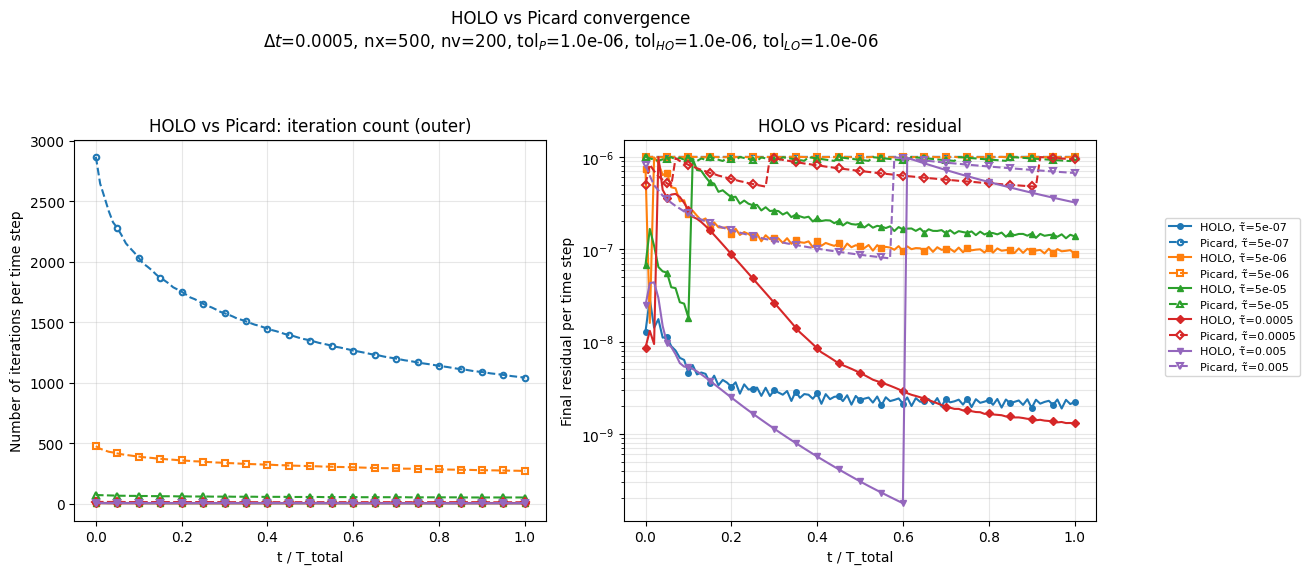

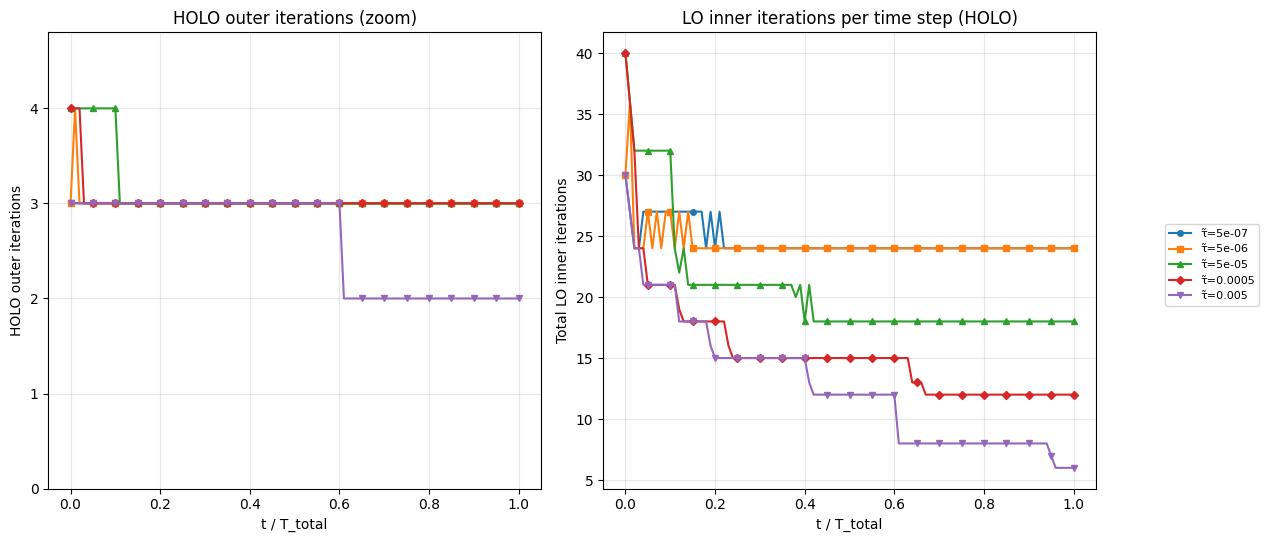

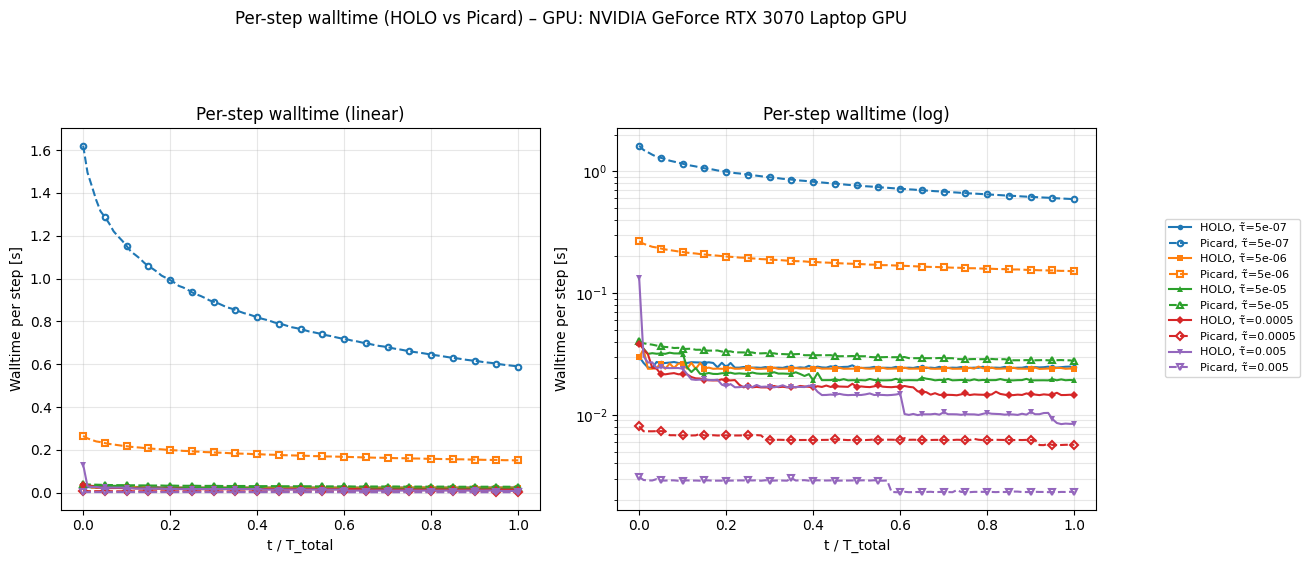

In [1]:
%run kineticEQ/tests/benchmarks/convergence_test.py --tau_tilde_list 5e-3 5e-4 5e-5 5e-6 5e-7

No modifications detected for re-loaded extension module gtsv_batch, skipping build step...
Loading extension module gtsv_batch...
No modifications detected for re-loaded extension module implicit_fused, skipping build step...
Loading extension module implicit_fused...
NoneType: None
No modifications detected for re-loaded extension module lo_blocktridiag, skipping build step...
Loading extension module lo_blocktridiag...
NoneType: None


initiaze complete:
  solver: None
 ---- hyperparameter ----
  hyperparameter: tau_tilde=1.0
 ---- space ----
  space: nx=500, dx=0.0020, Lx=1.0
 ---- velocity ----
  velocity: nv=200, dv=0.1005, v_max=10.0
 ---- time ----
  time: nt=101, dt=0.0005, T_total=0.05
  dtype: torch.float64
  device: cuda, GPU name: NVIDIA GeForce RTX 3070 Laptop GPU
--- compile cuSOLVER ---
--- compile CUDA fused implicit backend ---
--- fused CUDA backend loaded ---
--- compile LO block-tridiag backend ---
--- LO block-tridiag backend loaded ---
--- Convergence Test Start ---
--- tau_tilde: 0.05 ---
--- HOLO ---


Progress:   0%|          | 0/101 [00:00<?, ?it/s]

Progress: 100%|██████████| 101/101 [00:05<00:00, 19.93it/s]


--- PICARD ---


Progress: 100%|██████████| 101/101 [00:00<00:00, 289.29it/s]


--- tau_tilde: 0.005 ---
--- HOLO ---


Progress: 100%|██████████| 101/101 [00:05<00:00, 19.85it/s]


--- PICARD ---


Progress: 100%|██████████| 101/101 [00:00<00:00, 172.46it/s]


--- tau_tilde: 0.0005 ---
--- HOLO ---


Progress: 100%|██████████| 101/101 [00:06<00:00, 15.22it/s]


--- PICARD ---


Progress: 100%|██████████| 101/101 [00:01<00:00, 58.18it/s]


--- tau_tilde: 5e-05 ---
--- HOLO ---


Progress: 100%|██████████| 101/101 [00:10<00:00, 10.07it/s]


--- PICARD ---


Progress: 100%|██████████| 101/101 [00:11<00:00,  9.13it/s]


--- tau_tilde: 5e-06 ---
--- HOLO ---


Progress: 100%|██████████| 101/101 [00:10<00:00,  9.78it/s]


--- PICARD ---


Progress: 100%|██████████| 101/101 [01:32<00:00,  1.09it/s]


--- Convergence Test Completed ---
ベンチマーク結果を保存: Conv_bench.pkl  (0.22 MB)
ベンチマーク結果を読み込み: Conv_bench.pkl  (meta: {'saved_at': '2025-12-03T11:43:35', 'hostname': 'arlm-ASUS-TUF-Gaming-A15-FA506QR', 'torch_version': '2.7.1+cu126', 'device': 'cuda', 'dtype': 'torch.float64', 'solver': None})
収束性テストの図を保存: Conv_bench.png
HOLO-only 図を保存: Conv_bench_holo.png
Walltime 図を保存: Conv_bench_walltime.png


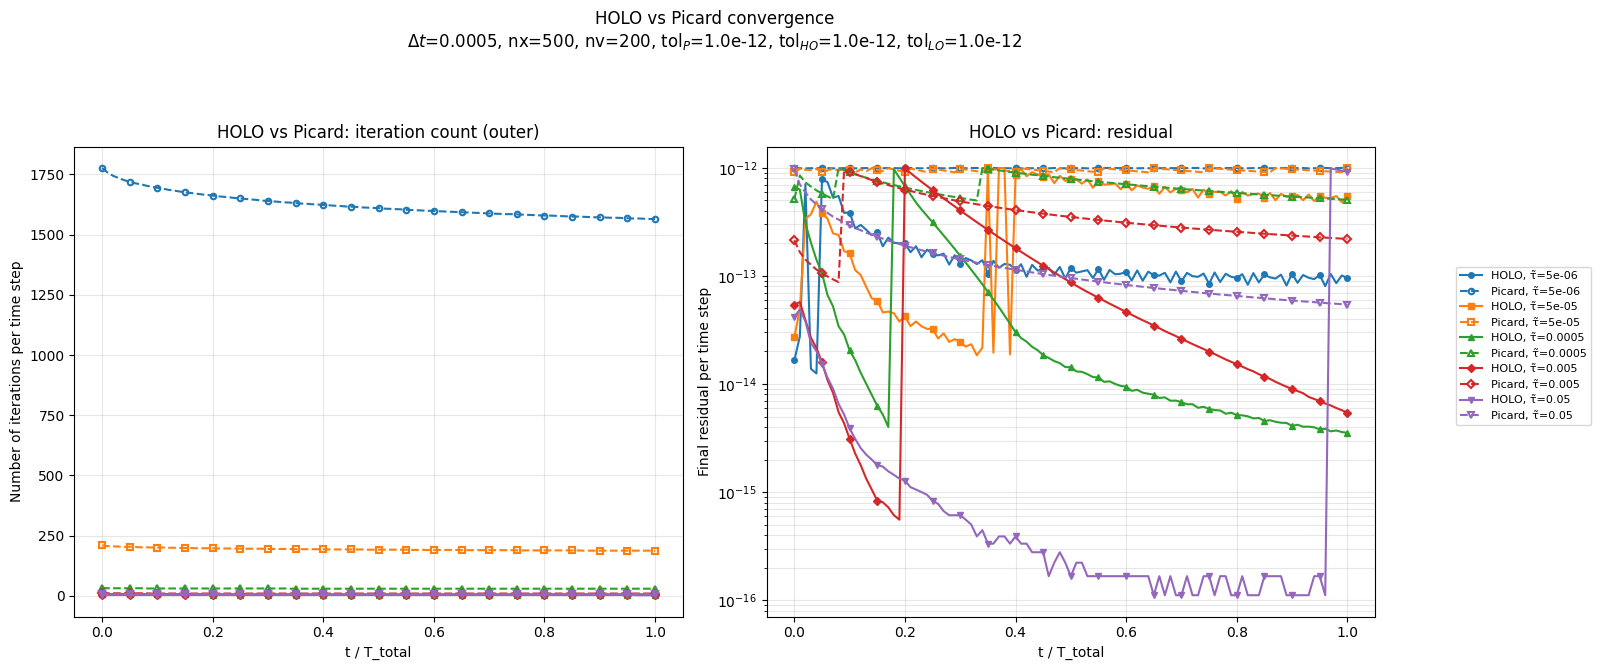

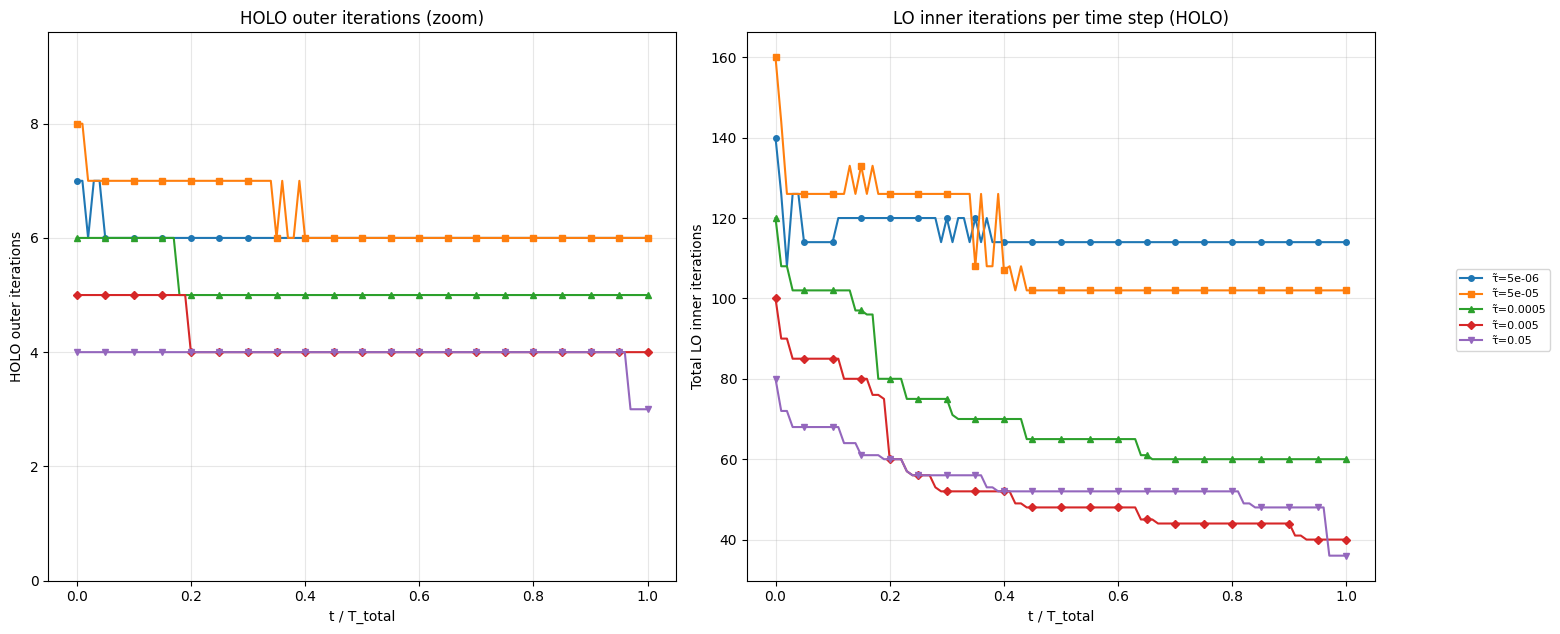

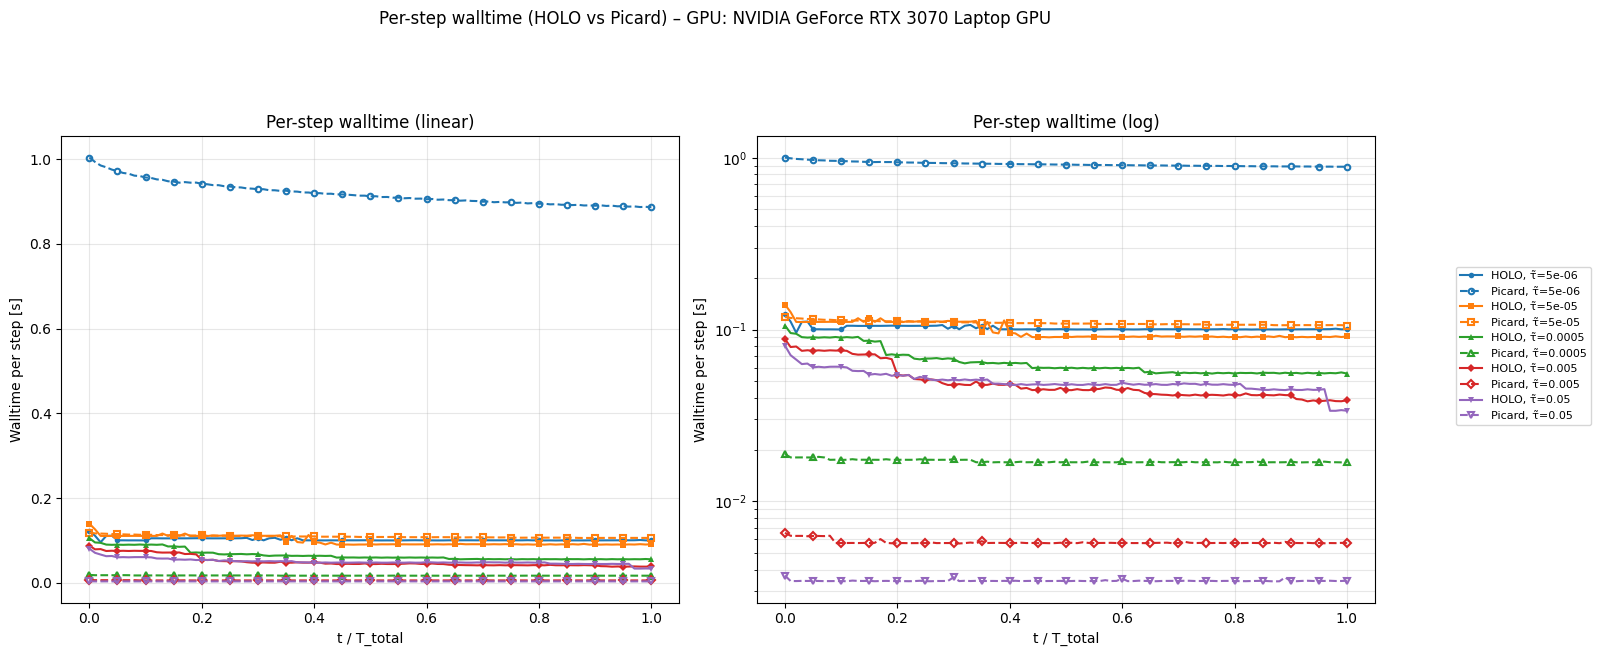

In [ ]:
from kineticEQ import BGK1DPlot

no_run = False

config = {
    "v_max": 10.0,
    "dt": 5e-4,
    "nv": 200,
    "nx": 500,

    # 陰解法パラメータ
    "picard_iter": 2048,
    "picard_tol": 1e-6,

    # HOLOパラメータ
    "ho_iter": 2048,
    "lo_iter": 2048,
    "ho_tol": 1e-6,
    "lo_tol": 1e-6,

    "initial_regions": [
        {"x_range": (0.0, 0.5), "n": 1.0,   "u": 0.0, "T": 1.0},
        {"x_range": (0.5, 1.0), "n": 0.125, "u": 0.0, "T": 0.8},
    ],
    "n_left": 1.0,   "u_left": 0.0, "T_left": 1.0,
    "n_right": 0.125,"u_right": 0.0,"T_right": 0.8,
    "T_total": 0.05,
    "dtype": "float64",
    "use_tqdm": True,
    "device": "cuda",
    "auto_compile": False,
}

sim = BGK1DPlot(**config)
if not no_run:
    conv_result = sim.run_convergence_test(tau_tilde_list=[5e-2, 5e-3, 5e-4, 5e-5, 5e-6])
    sim.save_benchmark_results(
        filename=f"Conv_bench.pkl",
        bench_results=conv_result,
    )

tmp = sim.load_benchmark_results(filename=f"Conv_bench.pkl")
sim.plot_convergence_results(tmp, figsize= (15, 7), show_plots=True, filename=f"Conv_bench.png")
